In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
import os
import re
import sys
from ijson import items
import json
import pprint
import configparser
from skimage.io import imread 
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

sys.path.append(os.path.abspath('../Module'))
import preprocessing
import visualize

config = configparser.ConfigParser()
config.read('../config.ini')

vg_json = config['PATHS']['vg-json']
vg_json_export = config['PATHS']['json-export']
image_dir = config['PATHS']['vg-images']

In [2]:
colors = preprocessing.basic_colors()

In [3]:
def plot_object(row, img_dir):
    
    try:
        image_id = row.image_id
        color = row.color
        color_pred = row.color_pred
        object_id = row.object_id
        name = row.object_name
        h = row.bb_h
        w = row.bb_w
        x = row.bb_x
        y = row.bb_y
    except:
        print ('entry missing')
        return
    
    filename = img_dir+str(image_id)+'.jpg'
    
    img = imread(filename)
    title = '{obj}, color (annotated):{clr}, color (predicted):{clr_pred}'.format(obj=name,clr=color,clr_pred=color_pred)
    
    # Bild plotten
    fig,ax = plt.subplots(figsize=(10,10))
    ax.imshow(img)
    ax.set_title(title)
    
    # BB hinzufügen
    rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    
    plt.show()
    
    pass

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Quelle: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


## DF mit Test-Split importieren

In [4]:
all_obj = pd.read_csv(vg_json_export+"extracted_data/test_df.csv", index_col=0)#.reset_index(drop=False)

# Frequente Objekte + CDOs + CNOs:
frequent_objects, color_diagnostic_objects, color_neutral_objects = preprocessing.freq_cdo_cno(all_obj, num_cdos=100, num_cnos=100, min_num=100)

# all_obj auf frequente Objekte reduzieren
freq_obj = all_obj.loc[all_obj.object_name.isin(frequent_objects)]

# DataFrames für CDOs und CNOs

cd_obj = freq_obj .loc[freq_obj.object_name.isin(color_diagnostic_objects.keys())]
cn_obj = freq_obj.loc[freq_obj.object_name.isin(color_neutral_objects)]

## Label- und Prediction-Arrays importieren

In [5]:
os.listdir(vg_json_export)

['results_baseline_arrays_lab.npz',
 'w2c_data.npz',
 'results_type_to_color.npz',
 '.ipynb_checkpoints',
 'vandeweijer2007',
 'results_baseline_arrays_hsv.npz',
 'extracted_data',
 'results_baseline_arrays.npz',
 'pixelwise_rgb_color.npz',
 'results_baseline_arrays_bgr.npz',
 'baseline_arrays.npz']

In [6]:
import_arrays = np.load(vg_json_export+'results_type_to_color.npz')
import_arrays.files

['test_y', 'test_x', 'train_y', 'dev_y', 'pred_y', 'dev_x', 'train_x']

In [7]:
predict_y = import_arrays['pred_y']
ids = predict_y[:,0:1]

In [8]:
# wenn id nicht in predictions
ids = import_arrays['test_x'][:,0:1]
predict_y = np.append(ids, predict_y, axis=1)

## Predictions und Test-DF zusammenführen
Resultat: Ein DF pro Bedingung (alle Objekte, CDO, CDO mit Memory Color, CDO ohne Memory Color)

In [9]:
# DataFrame aus Predictions (np-Array) erstellen
predict_df =  pd.DataFrame(data=predict_y[0:,1:],index=predict_y[0:,0],columns=[colors])
# Farbwort mit höchstem Wert (-> prognostiziertes Farbwort) (ergibt pd.Series)
pred_c = predict_df.idxmax(axis=1)
# pred-Series als Column von all_objects
predict_df.columns = [c[0] if type(c) == tuple else c for c in predict_df.columns]
# Tupel in Column-Namen auflösen
predict_df['color_pred'] = predict_df.idxmax(axis=1)
# all_objects mit all_obj (enthält ids, bbs, Objektnamen, Farbattribute) zusammenführen
predict_df = all_obj.join(predict_df, how='inner')

# Types anpassen
predict_df['color']=predict_df['color'].astype(str)
predict_df['color_pred']=predict_df['color_pred'].astype(str)

In [10]:
predict_cdo = predict_df.loc[cd_obj.index.to_list()]
predict_cno = predict_df.loc[cn_obj.index.to_list()]

## Ergebnisse überprüfen

### Scores

In [11]:
score_all = len(predict_df.loc[predict_df['color'] == predict_df['color_pred']]) / len(predict_df)
score_cdo = len(predict_cdo.loc[predict_cdo['color'] == predict_cdo['color_pred']]) / len(predict_cdo)
score_cno = len(predict_cno.loc[predict_cno['color'] == predict_cno['color_pred']]) / len(predict_cno)

print('All Objects: {a}, Color-Diagnostic Objects: {b}, Color-Neutral Objects: {c}'.format(a=score_all, b=score_cdo, c=score_cno))

All Objects: 0.4913945507487521, Color-Diagnostic Objects: 0.7350509391566133, Color-Neutral Objects: 0.30510667132091746


### Alle Objekte

In [12]:
predict_df.loc[predict_df['color'] != predict_df['color_pred']].sort_values('object_name')\
    .sample(n=5)

bb_h  bb_w  bb_x  bb_y   color  image_id  object_id object_name  \
514714.0    54    45   245   216     red   2358125    3337725      potato   
544385.0    30    17   410   216    pink   2354849    2106797        nose   
10255.0     36    35   198    35    pink      1337    1032181      flower   
283683.0    10    15   411   199  orange   2385789    1292979     sticker   
327441.0   252   141   152    99     red   2379738    3834639        sign   

             black      blue     brown      gray     green    orange  \
514714.0  0.012120  0.011669  0.372045  0.011621  0.011827  0.045871   
544385.0  0.620273  0.010037  0.127582  0.009649  0.001816  0.004933   
10255.0   0.007098  0.044923  0.002601  0.000504  0.020799  0.044860   
283683.0  0.092562  0.101912  0.003923  0.006336  0.061936  0.032560   
327441.0  0.111301  0.114136  0.011295  0.003354  0.090167  0.024049   

              pink    purple       red     white    yellow color_pred  
514714.0  0.011084  0.030712  0.192160  0.182225  0.118666      brown  
544385.0  0.129118  0.000314  0.020299  0.067959  0.008019      black  
10255.0   0.178540  0.139422  0.135005  0.192096  0.234153     yellow  
283683.0  0.019366  0.004465  0.142996  0.378097  0.155847      white  
327441.0  0.004512  0.002971  0.150603  0.393228  0.094384      white

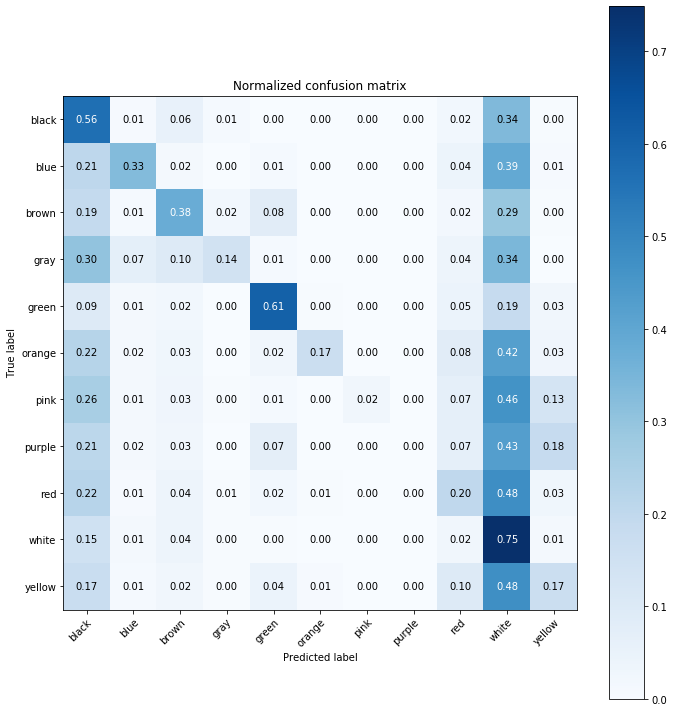

In [13]:
plot_confusion_matrix(predict_df.color, predict_df.color_pred, classes=colors, normalize=True)

In [14]:
len(predict_df.loc[predict_df['color'] == predict_df['color_pred']].sort_values('object_name')\
    .loc[predict_df['color'] == 'black']
   )

15283

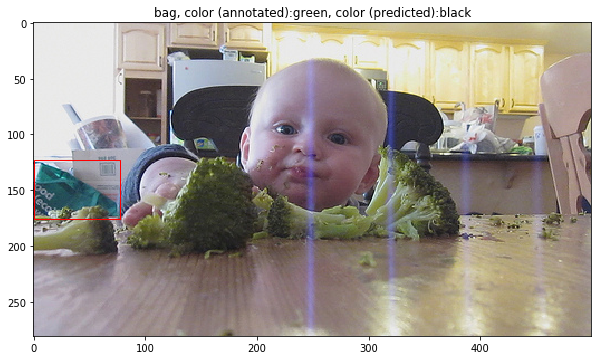

375810.0    None
dtype: object

In [15]:
predict_df.loc[predict_df['color'] != predict_df['color_pred']].sort_values('object_name')\
    .sample(n=1)\
    .apply(lambda x:plot_object(x, image_dir), axis=1)

### Color Diagnostic Objects

In [16]:
predict_cdo.loc[predict_cdo['color'] != predict_cdo['color_pred']].sort_values('object_name')\
    .sample(n=5)

bb_h  bb_w  bb_x  bb_y   color  image_id  object_id object_name  \
847722    51    82   198   177   brown   2317644    3176409         dog   
858255   413   371     2    84   black   2316618    3306564       plate   
412572   122   130   153     8  orange   2369634    1956804        hair   
383047   197   497     1   120   green   2373038    1740305       water   
649068   358    67   432    15  purple   2343463     923403        hair   

           black      blue     brown      gray     green    orange      pink  \
847722  0.275614  0.002353  0.314440  0.008993  0.001192  0.003469  0.001490   
858255  0.030580  0.052761  0.012557  0.004609  0.023279  0.009299  0.004931   
412572  0.329538  0.002211  0.488649  0.046209  0.001643  0.003772  0.002525   
383047  0.011066  0.548861  0.080326  0.039306  0.147683  0.000849  0.001094   
649068  0.329538  0.002211  0.488649  0.046209  0.001643  0.003772  0.002525   

          purple       red     white    yellow color_pred  
847722  0.000688  0.005649  0.366948  0.019164      white  
858255  0.003746  0.027854  0.796913  0.033471      white  
412572  0.002335  0.068735  0.052583  0.001799      brown  
383047  0.001010  0.000889  0.166282  0.002634       blue  
649068  0.002335  0.068735  0.052583  0.001799      brown

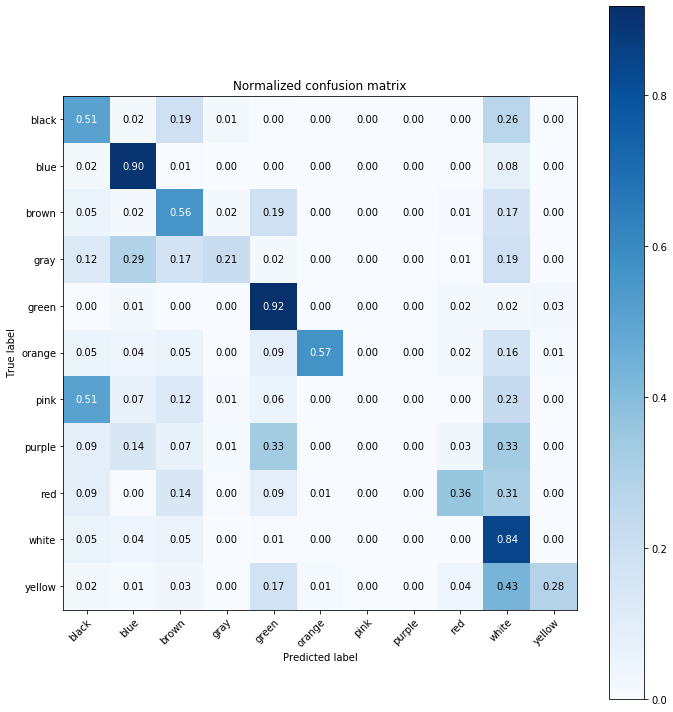

In [17]:
plot_confusion_matrix(predict_cdo.color, predict_cdo.color_pred, classes=colors, normalize=True)

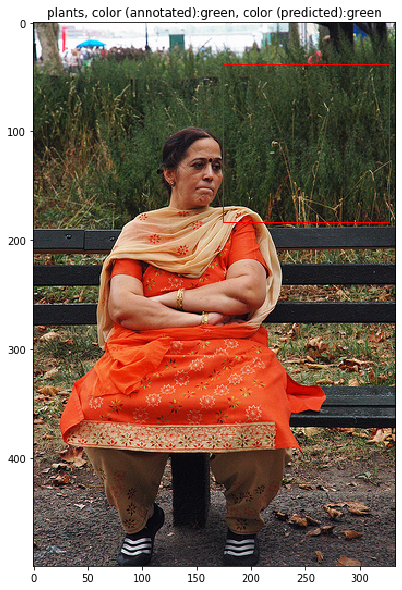

891055    None
dtype: object

In [18]:
predict_cdo.loc[predict_cdo['color'] == predict_cdo['color_pred']].sort_values('object_name')\
    .sample(n=1)\
    .apply(lambda x:plot_object(x, image_dir), axis=1)